<a href="https://colab.research.google.com/github/amirveyseh/test/blob/master/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Under the Hood

Handwritten digit recognition is a good first-lesson on image recognition for beginners.
<br />  
The MNIST dataset consists 60000 training examples and 10000 test examples, of digits 0-9, can be downloaded from [Yann Lecun's website](http://yann.lecun.com/exdb/mnist/).
<br />  
In this project we will:

- Implement a 2-layer neural network.
- Compute the forward pass and backward pass with softmax loss.
- Use the normlizaiton to help network converge.
- Use a stochastic gradient descent to optimize the loss function.

# Fully connected layer design

In this section, we define functions that are used to calculate forward propagationa and backward propagation in fully connected layer. Complete following unfinished functions.

In [0]:
def affine_forward(x, w, b):
    """
    Computes the forward pass for an affine (fully-connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
    examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and
    then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None      
    ###########################################################################
    # TODO: Implement the affine forward pass. Store the result in out. You   #
    # will need to reshape the input into rows.                               #
    ###########################################################################
    N = x.shape[0]
    D = np.prod(x.shape[1:])
    x_ND = np.reshape(x, (N, D))
    out = np.matmul(x,w)+b
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = (x, w, b)
    return out, cache


def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None
    
    N = x.shape[0]
    D = np.prod(x.shape[1:])
    x_ND = np.reshape(x, (N, D))

    dx_ND = np.dot(dout, w.T)
    dx = dx_ND.reshape(x.shape)    
    ###########################################################################
    # TODO: Implement the affine backward pass. Calculate dw and db.          #
    # About two lines of code.                                                #
    ###########################################################################

    dw = np.dot(x_ND.T, dout)
    db = np.sum(dout, axis=0).T

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dw, db


def relu_forward(x):
    """
    Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None
    ###########################################################################
    # TODO: Implement the ReLU forward pass. About One line of code.          #
    ###########################################################################
    
    out = np.maximum(x, 0)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    cache = x
    return out, cache


def relu_backward(dout, cache):
    """
    Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    ###########################################################################
    # TODO: Implement the ReLU backward pass. About one line of code.         #
    ###########################################################################
    dx = (x > 0) * dout
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx

def affine_relu_forward(x, w, b):
    """
    Convenience layer that perorms an affine transform followed by a ReLU

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache


def affine_relu_backward(dout, cache):
    """
    Backward pass for the affine-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

def softmax_loss(x, y):
    """
    Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
      class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
      0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    N = x.shape[0]
    loss = -np.sum(log_probs[np.arange(N), y]) / N
    dx = probs.copy()
    dx[np.arange(N), y] -= 1
    dx /= N
    return loss, dx


# Two layer neural network model

In this section, we will use above functions to assemble our two layer fully connected neural network model, and define model methods such as loss, train, and predict. Complete following unfinished functions.

In [0]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        scores = None        
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C). About 4 lines of codes.                                     #
        #############################################################################
        
        layer1_out, cache1 = affine_forward(X, W1, b1)        
        layer1_out_relu, cache1_relu = relu_forward(layer1_out)        
        layer2_out, cache2 = affine_forward(layer1_out_relu, W2, b2)
        scores = layer2_out
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None

        data_loss, dout = softmax_loss(scores, y)
        reg_loss = 0.5 * reg * (np.sum(W2*W2) + np.sum(W1*W1))

        loss = data_loss + reg_loss

        # Backward pass: compute gradients
        grads = {}

        dlayer1_out_relu, dW2, db2 = affine_backward(dout, cache2)
        dlayer1_out = relu_backward(dlayer1_out_relu, cache1_relu)
        dx, dW1, db1 = affine_backward(dlayer1_out, cache1)

        grads['b1'] = db1
        grads['W1'] = dW1 + 1 * reg * W1
        grads['b2'] = db2
        grads['W2'] = dW2 + 1 * reg * W2

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            
            indices = np.random.choice(X.shape[0], batch_size)            
            X_batch = np.take(X, indices, axis=0)            
            y_batch = np.take(y, indices, axis=0)
            
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above. About 4 lines of codes. #
            #########################################################################
            
            self.params['W1'] -= grads['W1']*learning_rate
            self.params['W2'] -= grads['W2']*learning_rate
            self.params['b1'] -= grads['b1']*learning_rate
            self.params['b2'] -= grads['b2']*learning_rate
            
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f val_acc %f' % (it,
                    num_iters, loss, (self.predict(X_val) == y_val).mean()))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C). About 4 lines of codes.                                     #
        #############################################################################
        
        layer1_out, _ = affine_relu_forward(X, W1, b1)
        layer2_out, _ = affine_forward(layer1_out, W2, b2)
        scores = layer2_out

        y_pred = np.argmax(scores, axis=1).reshape(X.shape[0],)
        
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred


In [68]:
from keras.datasets import mnist
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

From now on, you will see how the model you just built performs on MINIST handwritten digit dataset.

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [70]:
print("Loaded training images of shape:", X_train.shape)
print("Loaded training labels of shape:", y_train.shape)
print("Loaded test images of shape", X_test.shape)
print("Loaded test labels of shape", y_test.shape)

Loaded training images of shape: (60000, 28, 28)
Loaded training labels of shape: (60000,)
Loaded test images of shape (10000, 28, 28)
Loaded test labels of shape (10000,)


# Show some random images
Show some random images to get a gut feeling of how the data looks like.
Make sure `row * col` is less than the size of training set example number.
To adjust the size of plot size, just modify: `plt.rcParams['figure.figsize']` on the first code block.

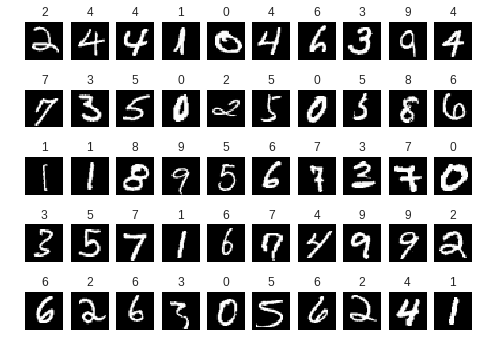

In [71]:
row, col = 5, 10
idx = np.random.choice(X_train.shape[0], row*col, replace=False)
for i in range(row):
    for j in range(col):
        plt_idx = idx[i*col+j]
        plt.subplot(row, col, i*col+j+1)
        plt.title(y_train[plt_idx])
        plt.imshow(X_train[plt_idx,:,:])
        plt.axis('off')

plt.show()

# Preprocess the data
## Preprocess Part.1
In this part, we preprocess the data by:

- Split training set data to train and validation.
- Normalize the data

In [72]:
# Split the data into train, val, and test sets. 
num_training = 50000
num_validation = 10000
num_test = 10000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0, dtype=X_train.dtype)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (50000, 28, 28)
Train labels shape:  (50000,)
Validation data shape:  (10000, 28, 28)
Validation labels shape:  (10000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


## Preprocess Part.2
Reshape the 3 dimension data to a `[N * (row * col)]` 2 dimension matrix.
`N` is the number of examples, `(row, col)` is the shape of an example image.

In [73]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (50000, 784)
Validation data shape:  (10000, 784)
Test data shape:  (10000, 784)


# Overfit Small Dataset
Training with a small dataset, i.e. a training set with 1000 example images, we should see an overfitting model.

In [74]:
# Preprocessing: reshape the image data into rows
X_train_small = X_train[:1000, :]
y_train_small = y_train[:1000]
# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train_small.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (1000, 784)
Validation data shape:  (10000, 784)
Test data shape:  (10000, 784)


In [75]:
input_size = 28 * 28
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train_small, y_train_small, X_val, y_val,
            num_iters=1000, batch_size=50,
            learning_rate=1e-3, learning_rate_decay=0.99,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
train_acc = (net.predict(X_train_small) == y_train_small).mean()
print('Validation accuracy: ', val_acc)
print('Train accuracy: ', train_acc)

iteration 0 / 1000: loss 2.302686 val_acc 0.118700
iteration 100 / 1000: loss 0.787256 val_acc 0.777500
iteration 200 / 1000: loss 0.364713 val_acc 0.830700
iteration 300 / 1000: loss 0.197922 val_acc 0.866300
iteration 400 / 1000: loss 0.148873 val_acc 0.862200
iteration 500 / 1000: loss 0.185125 val_acc 0.874300
iteration 600 / 1000: loss 0.171548 val_acc 0.873800
iteration 700 / 1000: loss 0.147391 val_acc 0.869300
iteration 800 / 1000: loss 0.142448 val_acc 0.878000
iteration 900 / 1000: loss 0.131803 val_acc 0.878200
Validation accuracy:  0.8786
Train accuracy:  1.0


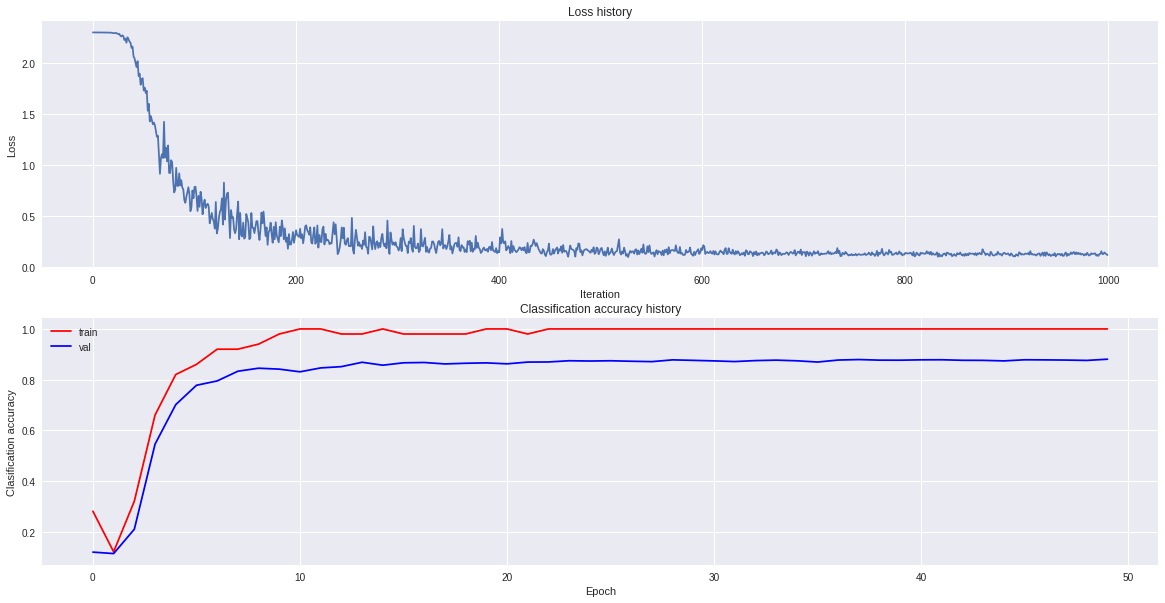

In [76]:
# Plot the loss function and train / validation accuracies
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'none'

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], 'r', label='train')
plt.plot(stats['val_acc_history'], 'b', label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

# Training
Train a two layer neural network, update gradients with mini-batch data, optimize the loss with SGD.


In [77]:
input_size = 28 * 28
hidden_size = 200
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=1e-3, learning_rate_decay=0.99,
            reg=0.2, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
train_acc = (net.predict(X_train) == y_train).mean()
print('Validation accuracy: ', val_acc)
print('Train accuracy: ', train_acc)

iteration 0 / 10000: loss 2.302712 val_acc 0.266000
iteration 100 / 10000: loss 0.574770 val_acc 0.827000
iteration 200 / 10000: loss 0.421494 val_acc 0.897600
iteration 300 / 10000: loss 0.309553 val_acc 0.912800
iteration 400 / 10000: loss 0.326307 val_acc 0.916800
iteration 500 / 10000: loss 0.251538 val_acc 0.931200
iteration 600 / 10000: loss 0.460949 val_acc 0.932200
iteration 700 / 10000: loss 0.245473 val_acc 0.937500
iteration 800 / 10000: loss 0.223880 val_acc 0.943600
iteration 900 / 10000: loss 0.236482 val_acc 0.950200
iteration 1000 / 10000: loss 0.268668 val_acc 0.950100
iteration 1100 / 10000: loss 0.249534 val_acc 0.952600
iteration 1200 / 10000: loss 0.234494 val_acc 0.951700
iteration 1300 / 10000: loss 0.227182 val_acc 0.953700
iteration 1400 / 10000: loss 0.191486 val_acc 0.957000
iteration 1500 / 10000: loss 0.223149 val_acc 0.957800
iteration 1600 / 10000: loss 0.140203 val_acc 0.962700
iteration 1700 / 10000: loss 0.149091 val_acc 0.961200
iteration 1800 / 10000

# Debug the training
The loss history indicates whether loss is converging.
Overfitting or underfitting can be observed from classification accuracy history.
If there is a big gap between training accuracy and validation accuracy curves, the model is highly possible overfitting. Else if the training accuracy is low, and validation accuracy alike, the model might be underfitting.
To avoid such occasions, fine tune the parameters with your observation on the plots.

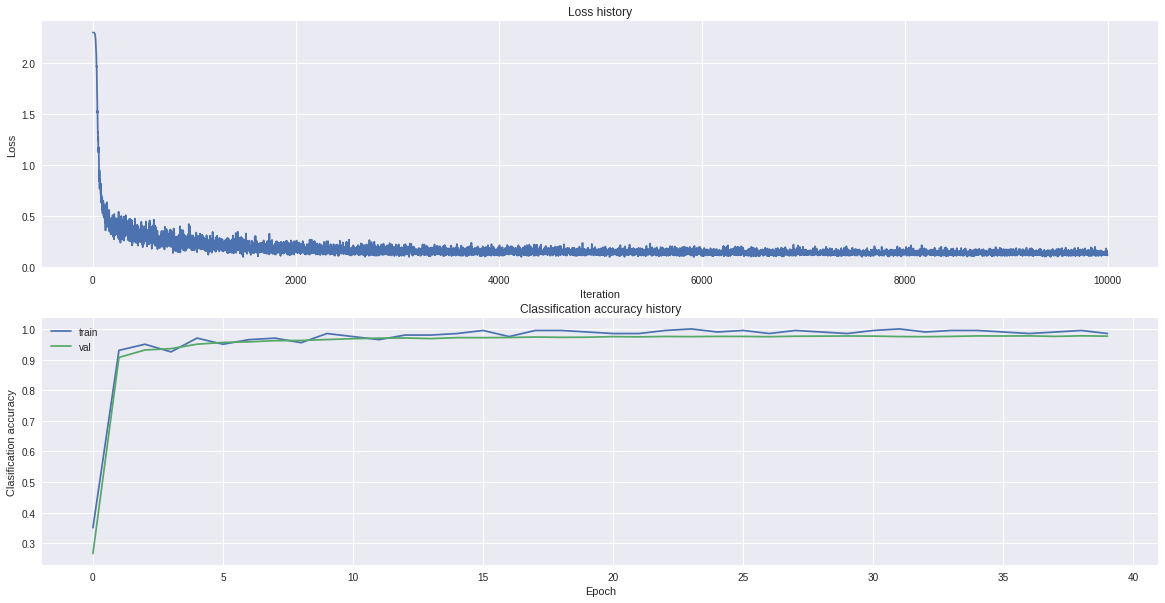

In [78]:
# Plot the loss function and train / validation accuracies
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'none'

plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

# Performance of the model
Now it's time to finally evaluate our model, with test set data.

In [79]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.9763


# Show some random image and predict using our model

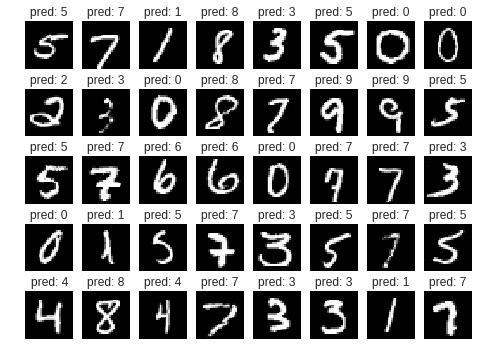

In [80]:
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

row, col = 5, 8
y_test_pred = net.predict(X_test)
X_test_image = X_test.reshape(-1, 28, 28)
idx = np.random.choice(X_test.shape[0], row*col, replace=False)
for i in range(row):
    for j in range(col):
        plt_idx = idx[i*col+j]
        plt.subplot(row, col, i*col+j+1)
        plt.title('pred: ' + str(y_test_pred[plt_idx]))
        plt.imshow(X_test_image[plt_idx,:,:])
        plt.axis('off')

plt.show()

# Conclusion
Congratulations! You have successfully finished this project! The 2-layer plain neural network should accquire an accuracy of ~97.75%. 